In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df_train = pd.read_csv("train.csv")

In [21]:
df_train = df_train.reindex(columns=['user_id', 'date', 'id1', 'id2', 'id3'])

### Does the number of impressions depend on the workday?
We find that there seems to be a variation of the number of unique users with the workday. More interestingly, we also find a large decline in the number of impressions in the second half of the time period.

In [8]:
%%time
# Determining the number of impressions per day
number_of_impressions_per_day = np.zeros(54)
number_of_unique_visitors_per_day = np.zeros(54)
for d in range(1, 55):
    tmp = df_train[df_train['date'] == d]['user_id']
    number_of_impressions_per_day[d-1] = tmp.size
    number_of_unique_visitors_per_day[d-1] = tmp.unique().size

CPU times: user 3.99 s, sys: 1.15 s, total: 5.14 s
Wall time: 5.16 s


In [9]:
daily_average_users, daily_average_impressions, day_count = np.zeros(7), np.zeros(7), np.zeros(7)
for d in range(0, 54):
    daily_average_users[d % 7] += number_of_unique_visitors_per_day[d]
    daily_average_impressions[d % 7] += number_of_impressions_per_day[d]
    day_count[d % 7] += 1
    
daily_average_users = np.divide(daily_average_users, day_count)
daily_average_impressions = np.divide(daily_average_impressions, day_count)

Text(0,0.5,'Average number of impressions')

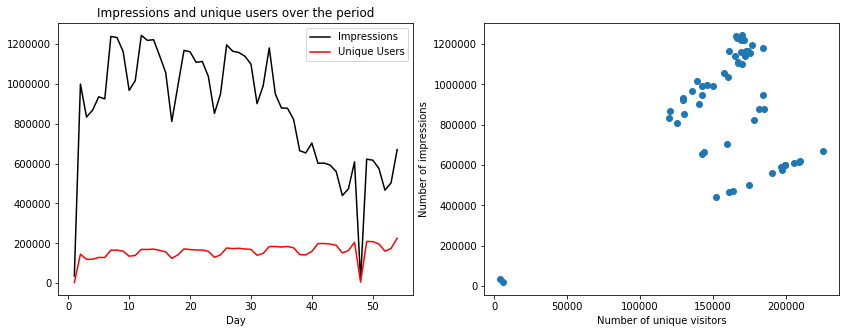

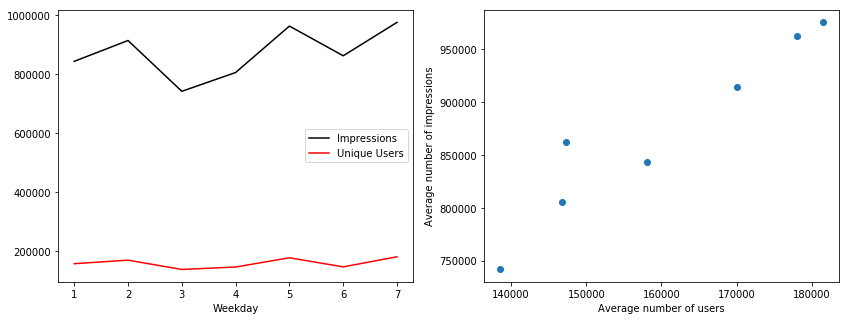

In [20]:
plt.figure(figsize=(14, 5))
# Plotting the time series
plt.subplot(1, 2, 1)
plt.plot(range(1, 55), number_of_impressions_per_day, 'k')
plt.plot(range(1, 55), number_of_unique_visitors_per_day, 'r')
plt.legend(['Impressions', 'Unique Users'])
plt.xlabel('Day')
plt.title('Impressions and unique users over the period')

# Evaluating the relationship between unique visitors per day
# and number of impressions
plt.subplot(1, 2, 2)
plt.scatter(number_of_unique_visitors_per_day, number_of_impressions_per_day)
plt.xlabel('Number of unique visitors')
plt.ylabel('Number of impressions')

## Plotting the average results
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,8), daily_average_impressions, 'k')
plt.plot(range(1,8), daily_average_users, 'r')
plt.legend(['Impressions', 'Unique Users'])
plt.xlabel('Weekday')

plt.subplot(1, 2, 2)
plt.scatter(daily_average_users, daily_average_impressions)
plt.xlabel('Average number of users')
plt.ylabel('Average number of impressions')


### How many impressions does the average user have? What is the distribution of the impressions per user?

In [22]:
grouped_user = df_train.groupby('user_id').count()
grouped_user['count'] = grouped_user['date']
grouped_user.drop(['date', 'id1', 'id2', 'id3'], inplace=True, axis=1)
grouped_user['log_count'] = np.log10(grouped_user['count'])

Some observations (details below):
- The median of the number of impressions is 9, but the median is 43.
- The distribution of the impressions seems to follow a power law.

In [24]:
grouped_user.describe()

,count,log_count
count,1.079572e+06,1.079572e+06
mean,4.353283e+01,1.006251e+00
std,1.558430e+02,6.900850e-01
min,1.000000e+00,0.000000e+00
25%,3.000000e+00,4.771213e-01
50%,9.000000e+00,9.542425e-01
75%,2.800000e+01,1.447158e+00
max,1.904100e+04,4.279690e+00


In [29]:
total_impressions = grouped_user['count'].sum(axis=0)
percentage_impressions = np.zeros(11)
ct = 0
for imps in [2 ** i for i in range(11)]:
    percentage_impressions[ct] = grouped_user[grouped_user['count'] >= imps]['count'].sum(axis=0) / total_impressions
    ct+=1

Text(0,0.5,'Fraction of visitors')

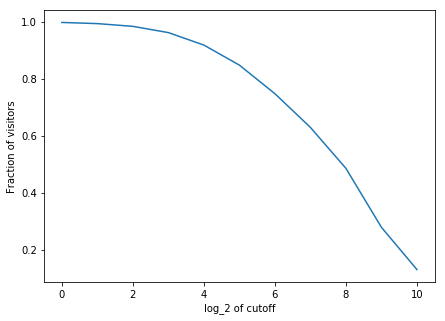

In [34]:
plt.figure(figsize=(7, 5))
plt.plot(range(11), percentage_impressions)
plt.xlabel('log_2 of cutoff')
plt.ylabel('Fraction of visitors')

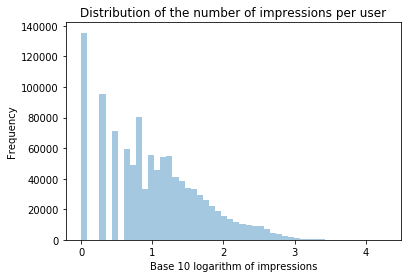

In [23]:
sns.distplot(grouped_user['log_count'], kde=False)
plt.title('Distribution of the number of impressions per user')
plt.xlabel('Base 10 logarithm of impressions')
plt.ylabel('Frequency')
plt.savefig('Logplot_Distribution_impressions.jpg')